In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
# import easyocr

matplotlib.rc("image", cmap="gray_r")

In [24]:
%matplotlib qt

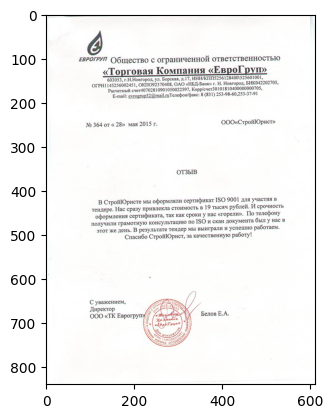

In [2]:
image = cv2.imread(r"D:\WORKS\TechTasks\DocData\2.jpg")
plt.imshow(image)

In [3]:
def binarize(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    return binary_image

In [64]:
gray_image  = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# blur_image = cv2.GaussianBlur(gray_image,(5,5),0)
blur_image = gray_image
plt.imshow(blur_image)

In [65]:
thresh_image = cv2.threshold(blur_image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
plt.imshow(thresh_image)

In [66]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
open_image = cv2.morphologyEx(thresh_image,cv2.MORPH_OPEN,kernel, iterations=1)
plt.imshow(open_image)

In [69]:
class TextPage:
    def __init__(self, image) -> None:
        nonZeroCoordinates = cv2.findNonZero(image)
        box = cv2.minAreaRect(nonZeroCoordinates)
        box_points = cv2.boxPoints(box)

        self.angle = box[2]
        self.x = int(box_points[0][0])
        self.y = int(box_points[0][1])
        self.dx = int(box_points[1][0] - self.x)
        self.dy = int(box_points[3][1] - self.y)

## Transform

## Rotation

In [70]:
def _open_transform(image, kernel_size):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    filtered_image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    return filtered_image


# TODO: find deriv from generator
def _hightlight_text(image):
    quality = np.array([np.count_nonzero(_open_transform(image, i)) for i in range(1, 10)])
    d_quality = np.diff(quality)
    best_kernel_size = np.where(d_quality == min(d_quality))[0][0] + 1

    return _open_transform(image, best_kernel_size)


def align(image):
    scale = 1

    angle = TextPage(_hightlight_text(image)).angle

    h, w = image.shape
    center = (w / 2, h / 2)
    # FIXME: check another rotations
    rotate_M = cv2.getRotationMatrix2D(center, 45 - np.abs(np.abs(angle) - 45), scale)
    aligned_image = cv2.warpAffine(
        image.copy(), rotate_M, (w, h), cv2.INTER_CUBIC, cv2.BORDER_REPLICATE
    )
    return aligned_image


def crop(image):
    border_widht = 50
    box = TextPage(_hightlight_text(image))
    cropped_image = image[box.y : box.y + box.dy, box.x : box.x + box.dx]
    return cv2.copyMakeBorder(
        cropped_image,
        top=border_widht,
        bottom=border_widht,
        left=border_widht,
        right=border_widht,
        borderType=cv2.BORDER_CONSTANT,
        value=(0, 0, 0),
    )

In [71]:
aligned_image = align(open_image)
plt.imshow(aligned_image)

In [72]:
cropped_image = crop(aligned_image)
plt.imshow(cropped_image)

In [73]:
def downscale_image(image, max_size=2048):
    """Shrink im until its longest dimension is <= max_dim.

    Returns new_image, scale (where scale <= 1).
    """
    x, y = image.shape
    max_dimention = max(x, y)
    if max_dimention <= max_size:
        return image

    scale = max_size / max_dimention
    return cv2.resize(image, fx=x * scale, fy=y * scale, interpolation=1)

## text boxes

### custom

In [74]:
contours_image = cv2.Canny(gray_image,100,200)
plt.imshow(contours_image)

In [75]:
box = TextPage(_hightlight_text(thresh_image))

In [76]:
box.angle

90.0

In [77]:
from scipy.ndimage import rank_filter

In [78]:
ranked_image = rank_filter(contours_image, rank=5, size=3)
plt.imshow(ranked_image)

In [32]:
def dilate(image, n_iterations):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,5))
    dilated_image = cv2.dilate(image, kernel, iterations=n_iterations)
    return dilated_image

In [33]:
dilated_image = dilate(ranked_image,15)
plt.imshow(dilated_image)

In [16]:
def test1(image, n):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,5))
    dilated_image = cv2.dilate(image, kernel, iterations=1)
    i=0
    while i<=n:
        i+=1
        dilated_image = cv2.dilate(dilated_image, kernel, iterations=1)
        yield cv2.connectedComponents(dilated_image)[0]-1

In [17]:
a = np.array(list(test1(ranked_image, 50)))

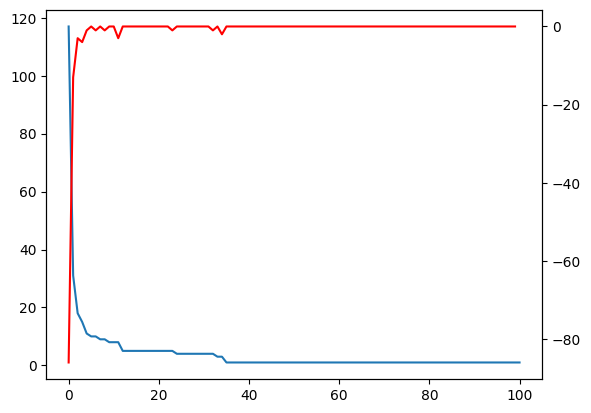

In [18]:
plt.plot(a)
plt.twinx().plot(np.diff(a),c='r')
# plt.twinx().plot(np.diff(a,2),c='g')

### easy OCR

In [20]:
import easyocr

In [21]:
reader = easyocr.Reader(lang_list=['ru'],gpu=False)

Using CPU. Note: This module is much faster with a GPU.


In [44]:
contours = reader.detect(img=thresh_image, width_ths=0.7,height_ths=0.7)[0][0]

In [45]:
BORDER_COLOR = 200
show_img = thresh_image.copy()
for contour in contours:
    x0, x1, y0, y1 = contour
    cv2.rectangle(show_img, (x0, y0), (x1, y1), BORDER_COLOR, 1)

plt.imshow(show_img)